# ZADANIE  – SAMODZIELNY ANALITYK EOBUWIE

<b>Wczytanie biblotek<b>

In [100]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm, skew
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

# Zadanie 1

<b> Wczytanie danych <b>

In [101]:
cena = pd.read_csv('cena bazowa.csv',delimiter=';')
zamowienia = pd.read_csv('zamowienia.csv',delimiter=';')
wyslane = pd.read_csv('wyslane.csv',delimiter=';')

In [102]:
cena.head()

,item_id,base_price
0,7447126,225
1,2696692,112
2,2883136,192
3,1984910,136
4,2242676,107


In [103]:
wyslane.head()

,order_id,item_id_1,item_id_2,item_id_3
0,314631735,2655227,9051607.0,NaN
1,802224752,1984910,4286301.0,NaN
2,716057036,2669985,1052038.0,NaN
3,125731133,5966397,NaN,NaN
4,12070864,6788106,9643817.0,NaN


In [104]:
zamowienia.order_date = pd.to_datetime(zamowienia.order_date)

In [105]:
zamowienia.head()

,order_id,client_id,order_date,KUPON
0,1462414,523933015,2019-06-29,NaN
1,1538139,814107372,2019-08-15,NaN
2,1838871,713139458,2019-08-19,NaN
3,1896544,123641536,2019-05-05,15%
4,1943852,602252913,2019-07-30,NaN


 <b>Zad 1.1 - W jakim dniu roku klienci złożyli najwięcej zamówień?<b>

In [106]:
zamowienia.order_date.value_counts().head(1)

2019-08-14    41
Name: order_date, dtype: int64

In [107]:
zamowienia.groupby(zamowienia.order_date).size().sort_values(ascending=False)[:1]

order_date
2019-08-14    41
dtype: int64

<b> Odp. 2019-08-14 <b>

<b> Zad 1.2 - Ilu klientów skorzystało z kuponu rabatowego w trakcie zakupów? <b>

In [108]:
sum(zamowienia[zamowienia['KUPON'].notna()].groupby('client_id')['order_id'].count())

998

<b> Odp. 998 klientów <b>

<b> Zad 1.3 - Ilu klientów zrobiło w analizowanym okresie więcej niż jedno zamówienie?<b>

In [109]:
sum(zamowienia['client_id'].value_counts()>1)

22

In [110]:
sum(zamowienia.groupby(zamowienia.client_id).count()['order_id']>1)

22

<b> Odp. 22 klientów<b>

<b> Zad 1.4 - Który z produktów cieszył się największym powodzeniem? Ilu klientów kupiło go ze zniżką?<b>

In [111]:
produkty = pd.merge(zamowienia,wyslane, on='order_id')

In [112]:
produkty.head()

,order_id,client_id,order_date,KUPON,item_id_1,item_id_2,item_id_3
0,1462414,523933015,2019-06-29,NaN,1115180,NaN,NaN
1,1538139,814107372,2019-08-15,NaN,7838989,3109031.0,4175443.0
2,1838871,713139458,2019-08-19,NaN,684194,NaN,NaN
3,1943852,602252913,2019-07-30,NaN,9051607,NaN,NaN
4,2143538,563294140,2019-08-04,40%,5801454,2077835.0,NaN


In [113]:
item1 = produkty[['KUPON','item_id_1']].rename(columns={"item_id_1": "item_id"})
item2 = produkty[produkty['item_id_2'].notna()].loc[:,['KUPON','item_id_2']].rename(columns={"item_id_2": "item_id"})
item3 = produkty[produkty['item_id_3'].notna()].loc[:,['KUPON','item_id_3']].rename(columns={"item_id_3": "item_id"})
item = pd.concat([item1,item2,item3])
item.item_id = item.item_id.astype('int')
item.head()

,KUPON,item_id
0,NaN,1115180
1,NaN,7838989
2,NaN,684194
3,NaN,9051607
4,40%,5801454


In [114]:
item['item_id'].value_counts().head(1)

4355722    70
Name: item_id, dtype: int64

In [115]:
item.groupby(item.item_id).size().max()

70

In [116]:
sum(item[item['item_id']==4355722]['KUPON'].notna())

11

<b> Odp. Największym powodzeniem cieszył się produkt o numerze id 4355722, którego ze zniżką zakupiło 11 osób<b>

<b> Zad 1.5. - Który produkt był najczęściej kupowany ze zniżką?<b>

In [117]:
item_znizka = item.dropna()
item_znizka.item_id.value_counts().head(1)

1554376    19
Name: item_id, dtype: int64

<b> Odp. Produkt o numerze id 1554376    <b>

<b> Zad 1.6. -Jaka była końcowa wartość wszystkich zamówień w badanym okresie?<b>

In [118]:
cena_item = pd.merge(item,cena, on='item_id', how='inner')

In [119]:
cena_item.head()

,KUPON,item_id,base_price
0,NaN,1115180,212
1,NaN,1115180,212
2,NaN,1115180,212
3,NaN,1115180,212
4,NaN,1115180,212


In [120]:
cena_item['KUPON'] = cena_item['KUPON'].fillna('0%')
cena_item['KUPON'] = cena_item['KUPON'].apply(lambda x: float(x[:-1])/100)
cena_item['koncowa_cena']= cena_item['base_price']-(cena_item['base_price']*cena_item['KUPON'])
cena_item['koncowa_cena'].sum()

794260.69

<b> Odp. Końcowa wartość zamówień w badanym okresie wyniosła 794260.69 zł <b>

# Zadanie 2

Prognoza liczby zamówień w styczniu i lutym 2020 roku.

<b> wczytanie danych<b>

In [121]:
df = pd.read_csv('predykcja.csv', delimiter=';')

Podstawowe informacje o analizowanym zbiorze danych

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
DATA          731 non-null object
zamowienia    731 non-null int64
wyprzedaż     73 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.3+ KB


In [123]:
df.head()

,DATA,zamowienia,wyprzedaż
0,2018-01-01,100,NaN
1,2018-01-02,94,NaN
2,2018-01-03,118,1.0
3,2018-01-04,114,1.0
4,2018-01-05,122,1.0


Przekształcenie danych do postaci pozwalającej na modelowanie

In [124]:
df['DATA']= pd.to_datetime(df['DATA'])
df.set_index(df['DATA'], inplace=True)
df.drop(['DATA'],axis=1,inplace=True)
df['wyprzedaż'].fillna(0,inplace=True)
df.dropna(inplace=True)
for col in df.columns:
    df[col] = df[col].astype('int64')

Stowrzenie zmiennej endogenicznej zawierającej informacje o przeszłych i przyszłych wyprzedażach

In [172]:
wyprzedaz = pd.DataFrame({'wyprzedaż':0},index=pd.date_range('2020-01-02','2020-02-29',freq='D'))
wyprzedaz.loc['2020-02-01': '2020-02-07']=1
df_wyprzedaz= df[['wyprzedaż']]
concat_wyprzedaz = pd.concat([df_wyprzedaz,wyprzedaz],axis=0,join='inner')
concat_wyprzedaz[-30:]

,wyprzedaż
2020-01-31,0
2020-02-01,1
2020-02-02,1
2020-02-03,1
2020-02-04,1
2020-02-05,1
2020-02-06,1
2020-02-07,1
2020-02-08,0
2020-02-09,0


Wizualizacja analizowanego szeregu czasowego

(array([17532, 17622, 17713, 17805, 17897, 17987, 18078, 18170, 18262],
       dtype=int64), <a list of 9 Text xticklabel objects>)

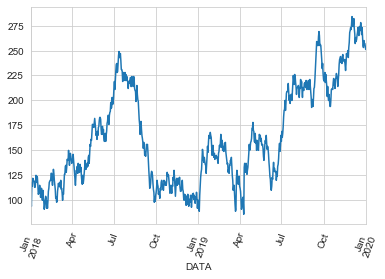

In [126]:
df.zamowienia.plot()
plt.xticks(rotation=70)

#  Analiza prognozowanego szeregu czasowego

Badanie własności rozkładu zmiennej objaśnianej


 mu = 163.82 and sigma = 50.60



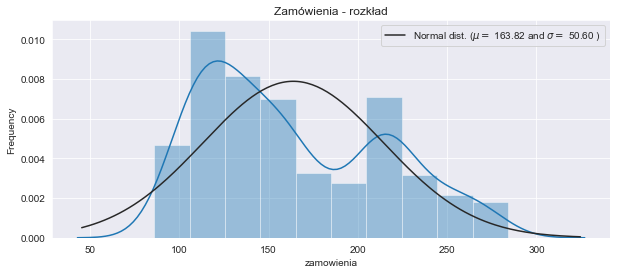

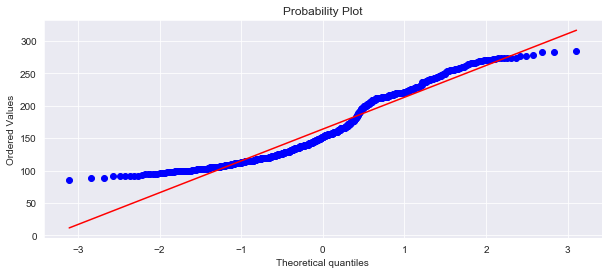

In [127]:

plt.figure(figsize=(10,4))
color = sns.color_palette()
sns.set_style('darkgrid')
sns.distplot(df['zamowienia'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['zamowienia'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Zamówienia - rozkład')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,4))
res = scs.probplot(df['zamowienia'], plot=plt)
plt.show()

Na podstawie wykresu rozkładu oraz wykresu normalności Q-Q zmiennej zamówienia, stwierdzamy że rozkład ten nie jest rozkładem normalnym. Podejęto próbę sprowadzenia rozkładu zmiennej do rozkładu normalnego przez transformację logarytmiczną.


 mu = 5.06 and sigma = 0.30



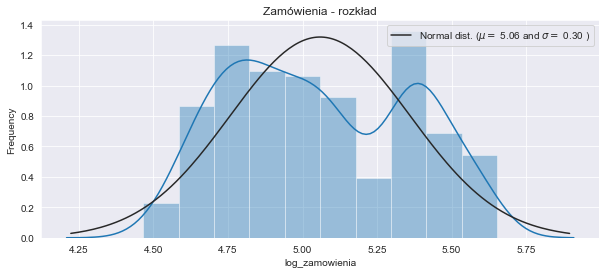

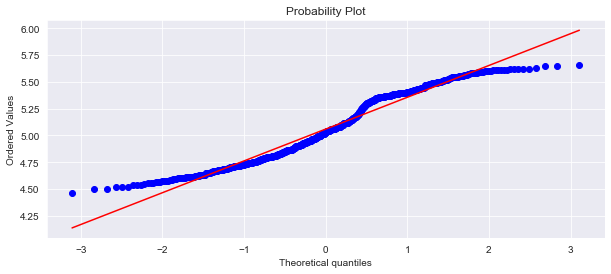

In [128]:
df["log_zamowienia"] = np.log1p(df["zamowienia"])
plt.figure(figsize=(10,4))
color = sns.color_palette()
sns.set_style('darkgrid')
sns.distplot(df['log_zamowienia'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['log_zamowienia'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Zamówienia - rozkład')

#Get also the QQ-plot
fig = plt.figure(figsize=(10,4))
res = scs.probplot(df['log_zamowienia'], plot=plt)
plt.show()

In [129]:
skew(df.zamowienia)

0.5207142496183889

In [130]:
skew(df.log_zamowienia)

0.1611655087942561

In [131]:
jarque_bera_test = scs.jarque_bera(df.log_zamowienia)
print('statistic={:.2f}, pvalue={:.2f}'.format(jarque_bera_test[0],jarque_bera_test[1]))


statistic=44.66, pvalue=0.00


Na podstawie test normalności jarque-bera stwierdzamy, że szereg czasowy nie ma rozkładu normalnego. Zlogarytmowanie zmiennej zamówienia pozwoliło jednak na zmniejszenie skośności  oraz ustabilizowanie wariancji procesu

<b> Dekompozycja szeregu czasowego<b>

In [132]:
sd = seasonal_decompose(df.log_zamowienia,freq=7)

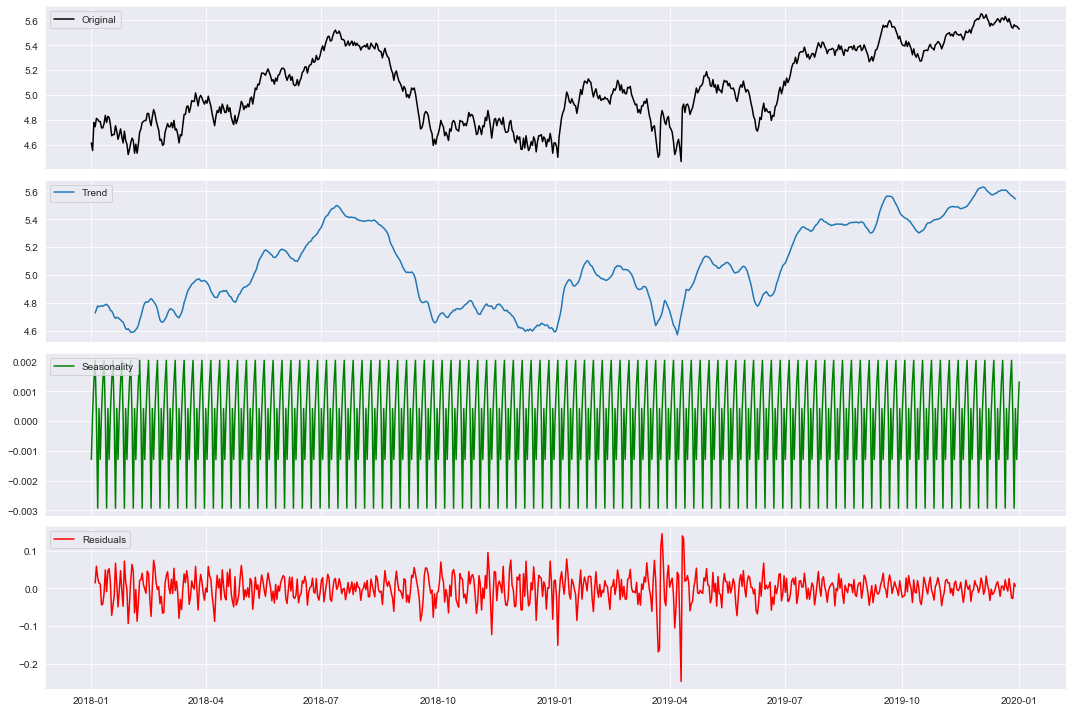

In [133]:
trend = sd.trend
seasonal = sd.seasonal
observed = sd.observed
res = sd.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False )
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(observed, 'k', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, 'g', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(res, 'r', label='Residuals')
axes[3].legend(loc='upper left')
plt.tight_layout()

Na podsawie wykresów wyodrębnionych składowych szergu czasowego, możemy wnioskać o występowaniu tygodniowej sezonowości oraz braku znaczącego trendu w ramach analizowanego okresu referencyjnego.

<b>Badanie występowania autokorelacji<b>

In [134]:
df['constant']=1 
model = sm.OLS(df["log_zamowienia"].values,df['constant'])
results = model.fit()
ljungbox = sm.stats.acorr_ljungbox(results.resid, lags=[1,2,3,4,5,6,7,8,9,10])
ljunbox_test = pd.DataFrame({'Wartość testu':ljungbox[0],
             'p-value': ljungbox[1]}, index=range(1,11))
ljunbox_test.index.name = 'Lags'
ljunbox_test

,Wartość testu,p-value
Lags,,
1,711.695564,8.559666e-157
2,1402.860298,2.359157e-305
3,2077.189416,0.000000e+00
4,2735.074581,0.000000e+00
5,3377.593837,0.000000e+00
6,4004.224647,0.000000e+00
7,4617.083848,0.000000e+00
8,5217.121457,0.000000e+00
9,5804.328652,0.000000e+00


Na podstawie testu ljunga-boxa stwierdzamy, że występuje autokorelacja powyżej 10 rzędu.

<b> Badanie stacjonarności szeregu czasowego <b>

In [135]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [136]:
adf_test(df.log_zamowienia)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.083121
p-value                   0.251356
# lags used               0.000000
# observations          730.000000
critical value (1%)      -3.439340
critical value (5%)      -2.865507
critical value (10%)     -2.568883
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [137]:
adf_test(pd.Series(np.diff(df.log_zamowienia)))

Augmented Dickey-Fuller Test: 
ADF test statistic      -27.953220
p-value                   0.000000
# lags used               0.000000
# observations          729.000000
critical value (1%)      -3.439352
critical value (5%)      -2.865513
critical value (10%)     -2.568886
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Test ADF wykazał, że szereg czasowy jest zintegrowany pierwszego stopnia tzn. pierwsze różnice szeregu są stacjonarne.

In [138]:
df['constant']=1
model = sm.OLS(np.diff(df["log_zamowienia"]),df['constant'][:-1])
results = model.fit()
ljungbox = sm.stats.acorr_ljungbox(results.resid, lags=[1,2,3,4,5,6,7,8,9,10])
ljunbox_test = pd.DataFrame({'Wartość testu':ljungbox[0],
             'p-value': ljungbox[1]}, index=range(1,11))
ljunbox_test.index.name = 'Lags'
ljunbox_test

,Wartość testu,p-value
Lags,,
1,0.892800,0.344720
2,2.216032,0.330213
3,2.404574,0.492784
4,2.516747,0.641640
5,3.003119,0.699505
6,6.267553,0.393896
7,7.209616,0.407386
8,7.515784,0.482137
9,7.785324,0.555917


Dla pierwszych różnic badanego szeregu czasowego nie występuje autokorelacja

<b>Wizualizacja wykresów autokorelacji oraz średnich ruchomych dla zmiennej zamówienia.<b>

In [139]:
diff_zamowienia = pd.Series(np.diff(df.log_zamowienia))
def tsplot(df, lags=None, style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=[10,8])
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        diff_zamowienia.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(diff_zamowienia, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(diff_zamowienia, lags=lags, ax=pacf_ax, alpha=0.5)
        df.zamowienia.rolling(30).mean().plot(ax=qq_ax)
        qq_ax.set_title('Moving avarage 30-days')
        df.zamowienia.rolling(45).mean().plot(ax=pp_ax)
        pp_ax.set_title('Moving avarage 45-days')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

       
    return

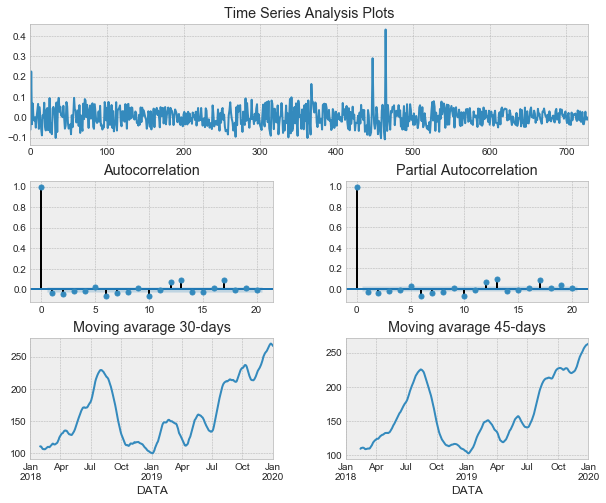

In [140]:
_ = tsplot(df, lags=20)

# Prognozowanie

Do prognozowania ilości zamówień w styczniu i lutym postanowiono wykorzystać modele SARIMAX i Prophet. Modele te pozwalają na ujęcie dokładnych wzorców szeregu czasowego, w którym mamy doczynienia z występowaniem nieliniowego trendu i sezonowości. Ponadto umożliwiają modelowanie w poraciu o dodatkowe zmienne endogeniczne.

# Model SARIMAX

Na podstawia wartości kryterium informacyjnych AIC dokonujemy wyboru rzędu procesów AR (p) i MA (q)  minimalizując utracone informacje spowodowane brakiem dopoasowania i złożonością modelu. Do badania stacjonarności zastosowano test kpss (Kwiatkowski–Phillips–Schmidt–Shin)

In [143]:
stepwise_fit = auto_arima(df['log_zamowienia'], start_p=0, start_q=0,
                          max_p=4, max_q=4, m=7,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 50, random=True, n_iter=30, test='kpss')        

stepwise_fit.summary()

Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 1, 7); AIC=-2371.375, BIC=-2330.038, Fit time=2.289 seconds
Fit ARIMA: order=(2, 1, 4) seasonal_order=(2, 0, 1, 7); AIC=-2367.801, BIC=-2317.278, Fit time=3.355 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=-2379.108, BIC=-2356.142, Fit time=1.638 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 7); AIC=-2378.264, BIC=-2355.299, Fit time=1.413 seconds
Fit ARIMA: order=(0, 1, 4) seasonal_order=(1, 0, 1, 7); AIC=-2373.099, BIC=-2336.355, Fit time=2.335 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 2, 7); AIC=-2369.491, BIC=-2323.560, Fit time=3.693 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(2, 0, 1, 7); AIC=-2372.990, BIC=-2336.245, Fit time=1.731 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=-2376.575, BIC=-2349.017, Fit time=1.878 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 7); AIC=-2376.122, BIC=-2353.157, Fit time=0.700 seconds
Fit ARIMA: order=(2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  731
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 7)   Log Likelihood                1194.017
Date:                           Wed, 30 Sep 2020   AIC                          -2380.033
Time:                                   19:11:16   BIC                          -2361.661
Sample:                                        0   HQIC                         -2372.945
                                           - 731                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.635      0.526      -0.001       0.002
ar.S.L7        0.6329      0.325      1.948      0.051      -0.004       1.270
ma.S.L7       -0.6830      0.306     -2.229      0.026      -1.284      -0.082
sigma2         0.0022   6.36e-05     34.918      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       41.54   Jarque-Bera (JB):              3290.36
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ostatecznie model przyjmuje następujący kształt - SARIMAX(0, 1, 0)x(1, 0, 1, 7)	

<b> Budowa modelu SARIMA(0, 1, 0)x(1, 0, 1, 7) <b>

In [144]:
model1 = SARIMAX(df['log_zamowienia'], order=(0,1,0) , seasonal_order=(1,0,1,7))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                    log_zamowienia   No. Observations:                  731
Model:             SARIMAX(0, 1, 0)x(1, 0, 1, 7)   Log Likelihood                1192.723
Date:                           Wed, 30 Sep 2020   AIC                          -2379.447
Time:                                   19:12:24   BIC                          -2365.668
Sample:                               01-01-2018   HQIC                         -2374.131
                                    - 01-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.0996      1.099     -0.091      0.928      -2.253       2.054
ma.S.L7        0.0648      1.103      0.059      0.953      -2.098       2.227
sigma2         0.0022   5.47e-05     40.748      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       43.71   Jarque-Bera (JB):              3592.79
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Określenie przedziału prognozy

In [145]:
start=len(df)
end=len(df)+ len(wyprzedaz)-1
predictions1 = results1.predict(start,end,typ='levels').rename('SARIMAX Prediction')

<b>Wizualizacja prognozy<b>

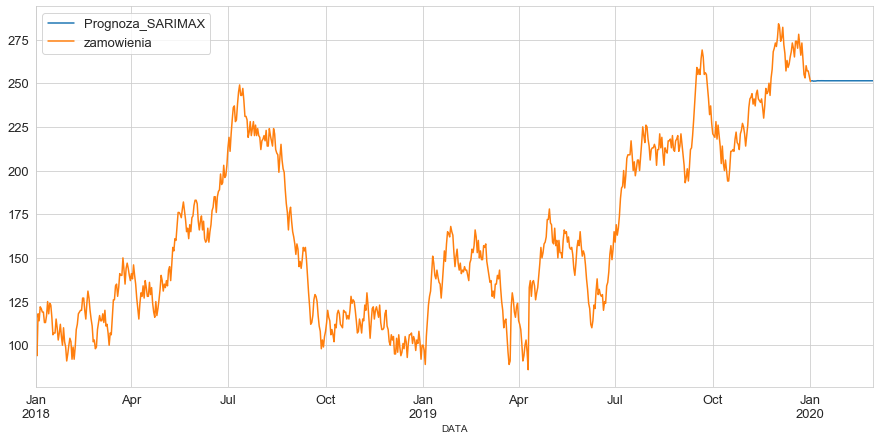

In [146]:
prognoza_plot=pd.DataFrame()
prognoza_plot['Prognoza_SARIMAX']=np.expm1(predictions1)
sns.set_style('whitegrid')
ax=prognoza_plot.plot(figsize=(15,7))
df.zamowienia.plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

<b> Budowa modelu SARIMAX (0, 1, 0)x(1, 0, 1, 7) z uwzględnieniem wyprzedaży jako zmiennej egzogenicznej <b>

In [147]:
model2 = SARIMAX(df['log_zamowienia'],exog=concat_wyprzedaz[:-59],order=(0,1,1) , seasonal_order=(1,0,1,7))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                    log_zamowienia   No. Observations:                  731
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1219.618
Date:                           Wed, 30 Sep 2020   AIC                          -2429.236
Time:                                   19:12:27   BIC                          -2406.271
Sample:                               01-01-2018   HQIC                         -2420.376
                                    - 01-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wyprzedaż      0.0825      0.005     16.135      0.000       0.072       0.092
ma.L1         -0.0360      0.034     -1.065      0.287      -0.102       0.030
ar.S.L7        0.6171      0.280      2.206      0.027       0.069       1.165
ma.S.L7       -0.6783      0.261     -2.596      0.009      -1.191      -0.166
sigma2         0.0021   8.54e-05     24.260      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       48.18   Jarque-Bera (JB):               459.98
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
start=len(df)
end=len(df)+ len(wyprzedaz)-1
predictions2 = results2.predict(start,end,exog=concat_wyprzedaz[-59:],typ='levels').rename('SARIMAX Prediction')

<b>Wizualizacja prognozy<b>

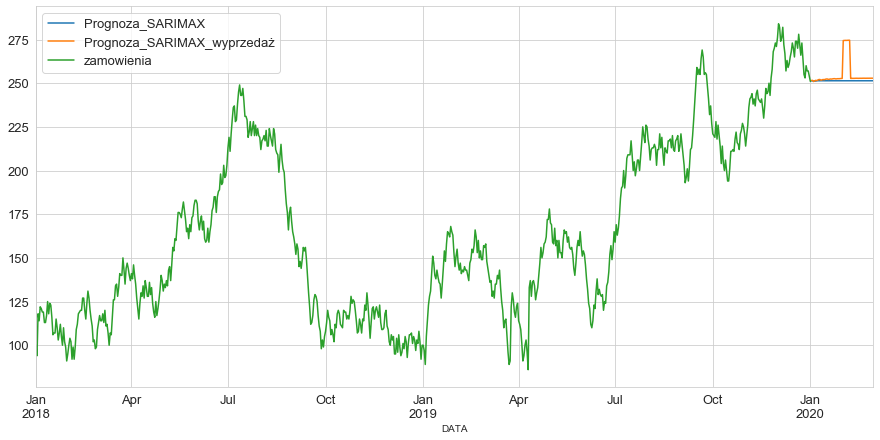

In [149]:
prognoza_plot['Prognoza_SARIMAX_wyprzedaż']= np.expm1(predictions2)
ax=prognoza_plot.plot(figsize=(15,7))
df.zamowienia.plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

# Model Prophet

<b> Przekształcenie tabeli danych do formy pozwalającej modelować algorytmem Prophet <b>

In [150]:

df_prophet = df[['zamowienia']]

In [151]:
df_prophet.reset_index(inplace=True)
df_prophet.head()

,DATA,zamowienia
0,2018-01-01,100
1,2018-01-02,94
2,2018-01-03,118
3,2018-01-04,114
4,2018-01-05,122


In [152]:

df_prophet.columns = ['ds','y']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
ds    731 non-null datetime64[ns]
y     731 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


<b> Budowa modelu Prophet z tygodniową sezonowością<b>

In [153]:

p = Prophet(      changepoint_range=0.95,
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.01,
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  )
p.fit(df_prophet)
future = p.make_future_dataframe(periods=59)
predictions_p = p.predict(future)

In [154]:

prop1 = predictions_p[['ds','yhat']][-59:]

<b< Wizualizacja prognozy oraz składowych prognozy <b>

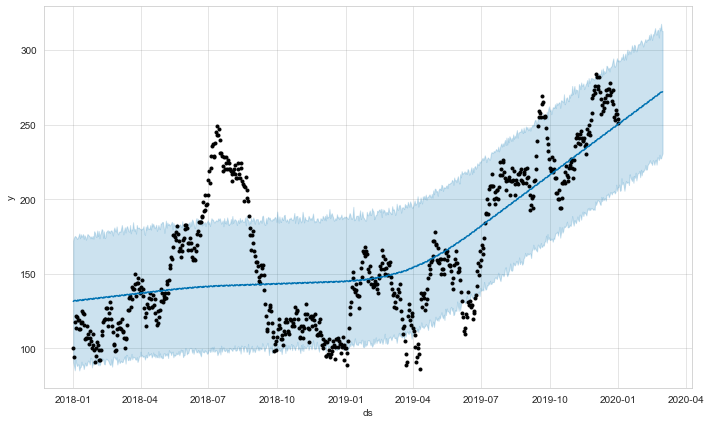

In [155]:
p.plot(predictions_p);

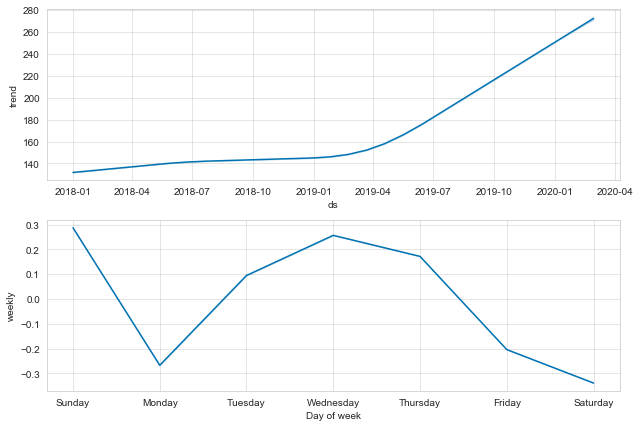

In [156]:
p.plot_components(predictions_p);

Na podstawie składowych szeregu czasowego wygenerowanych za pomocą algorytmu Prophet, zauważamy pojawiejnie się trendu wzrostowego wraz z początkiem 2019 roku. Dodatkowo wykres tygodniowej sezonowości dostarcza nam informacji na temat zachowań konsumenckich tj. najwięcej zamówień odnotowano w niedzielę i w środku tygodnia, natomiast najmniej w poniedziałek pod koniec tygodnia (piątek, sobota).

In [157]:
prop1.columns = ['DATE', 'Pred_prophet']
prop1 = pd.DataFrame(prop1)
prop1.set_index(prop1.DATE,inplace=True)
prop1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-01-02 to 2020-02-29
Data columns (total 2 columns):
DATE            59 non-null datetime64[ns]
Pred_prophet    59 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


<b>Wizualizacja prognozy<b>

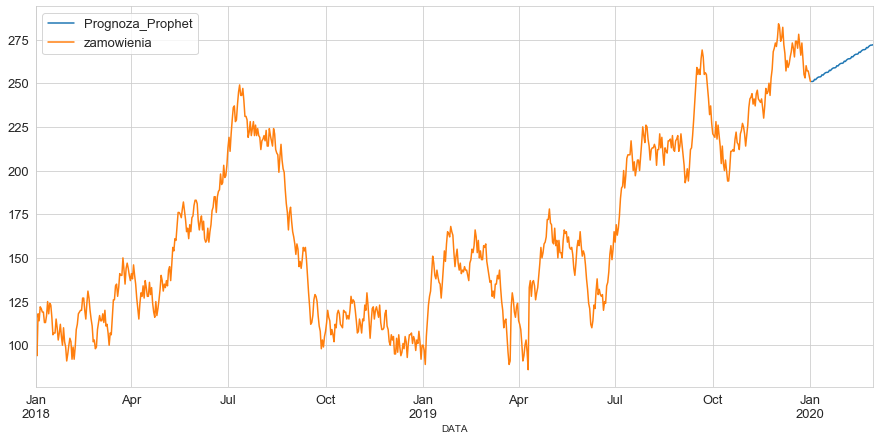

In [158]:
prophet_plot=pd.DataFrame()
prophet_plot['Prognoza_Prophet'] = prop1['Pred_prophet']
ax=prophet_plot.plot(figsize=(15,7))
df.zamowienia.plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

<b> Tworzenie tabeli danych z informacją o przeszłych i przyszłych wyprzedażach<b>

In [159]:
df_holiday = concat_wyprzedaz
df_holiday.reset_index(inplace=True)
df_holiday.head()

,index,wyprzedaż
0,2018-01-01,0
1,2018-01-02,0
2,2018-01-03,1
3,2018-01-04,1
4,2018-01-05,1


In [160]:
holiday_data = df_holiday[df_holiday['wyprzedaż']==1].loc[:,'index'].values
holidays = pd.DataFrame({'holiday': 'wyprzedaż',
                      'ds': pd.to_datetime(holiday_data)})

<b> Budowa modelu Prophet z informacją o wyprzedażach <b>

In [161]:
ph = Prophet(holidays=holidays,
                 yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                 changepoint_range=0.95,
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.01)
ph.fit(df_prophet)
futureh = ph.make_future_dataframe(periods=59)
predictions_h = ph.predict(future)

In [162]:
prop2 = predictions_h[['ds','yhat']][-59:]

In [163]:
prop2.columns = ['DATE', 'Pred_prophet_wyprzedaz']
prop2 = pd.DataFrame(prop2)
prop2.set_index(prop2.DATE,inplace=True)
prop2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-01-02 to 2020-02-29
Data columns (total 2 columns):
DATE                      59 non-null datetime64[ns]
Pred_prophet_wyprzedaz    59 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


<b>Wizualizacja prognozy<b>

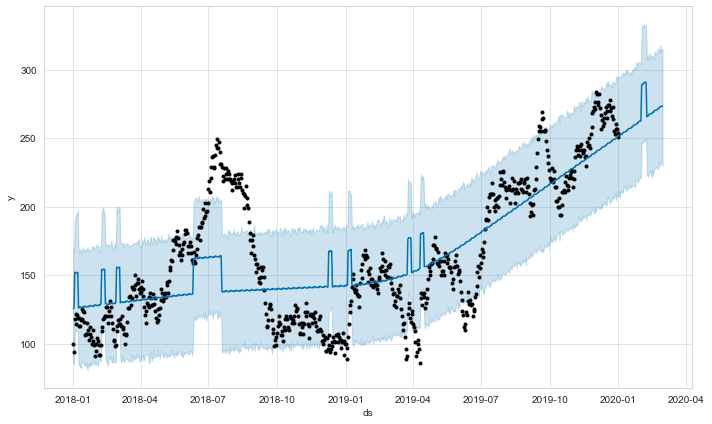

In [164]:
p.plot(predictions_h);

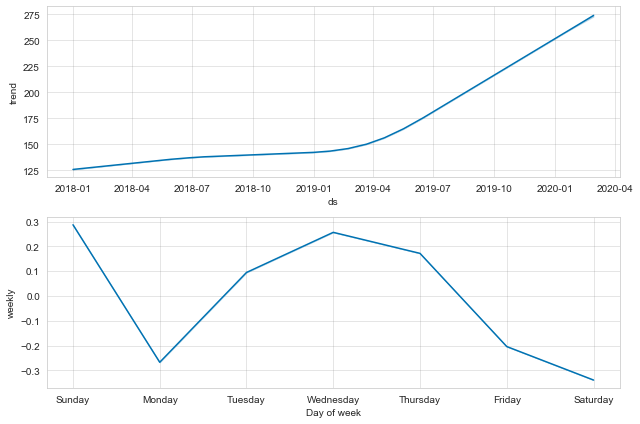

In [165]:
p.plot_components(predictions_h);

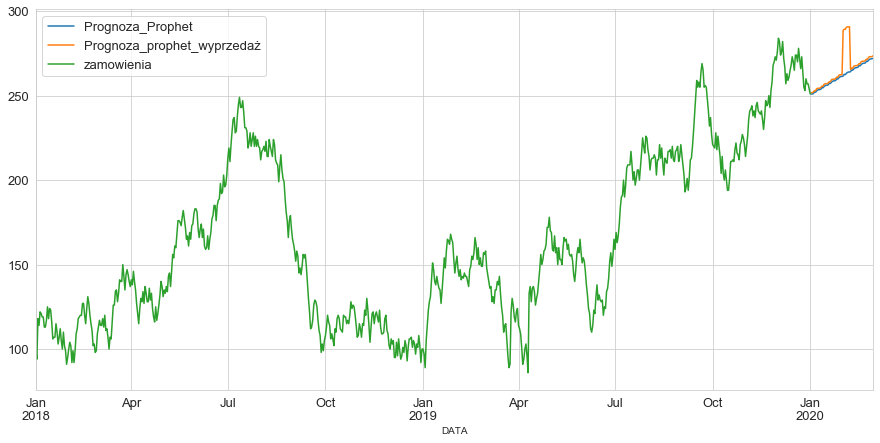

In [166]:
prophet_plot['Prognoza_prophet_wyprzedaż'] = prop2['Pred_prophet_wyprzedaz']
ax=prophet_plot.plot(figsize=(15,7))
df.zamowienia.plot(ax=ax, fontsize=13)
plt.legend(loc='best', prop={'size': 13})

<b> Badanie korelacji między zmienną zamówienia i zmienną wyprzedaż<b>

In [167]:
def correlation_ratio(categories, measurements):
        fcat, _ = pd.factorize(categories)
        cat_num = np.max(fcat)+1
        y_avg_array = np.zeros(cat_num)
        n_array = np.zeros(cat_num)
        for i in range(0,cat_num):
            cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            n_array[i] = len(cat_measures)
            y_avg_array[i] = np.average(cat_measures)
        y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        if numerator == 0:
            eta = 0.0
        else:
            eta = numerator/denominator
        return eta

In [168]:
correlation_ratio(df.zamowienia,df.wyprzedaż)

0.30509616925384925

Do badania korelacji między zmienną ilościową i jakościową zastosowano współczynnik korelacji Eta, gdzie wartości bliskie zeru wskazują na słaby związek pomiędzy zmiennymi, a bliskie 1 na silny związek. W tym przypadku można mówić, że między zmiennymi występuje stosunkowo słaba korelacja.

# Podsumowanie wartości prognoz za styczeń i luty dla różnych modeli

In [169]:

wyniki = pd.concat([prophet_plot,prognoza_plot], axis=1).dropna()

In [170]:
wyniki.resample('M').sum().apply(lambda x: round(x,0).astype('int'))


,Prognoza_Prophet,Prognoza_prophet_wyprzedaż,Prognoza_SARIMAX,Prognoza_SARIMAX_wyprzedaż
2020-01-31,7686,7716,7541,7564
2020-02-29,7747,7965,7290,7483
